# Double Descent Experiments on MNIST

## 1) Import libraries and set device

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2) Load MNIST, subsample 4000 training points, and define helper functions

In [ ]:
# Load MNIST with raw ToTensor (no normalization yet)
full_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_ds = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

# Subsample 4,000 random training examples for speed
n = 4000
indices = np.random.permutation(len(full_train))[:n]
train_ds = Subset(full_train, indices)

# Convert labels to one-hot vectors
def one_hot(labels, C=10):
    return torch.eye(C, device=labels.device)[labels]

# Build a two-layer fully connected network of width w (no dropout)
def make_model(w, reuse_from=None):
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, w),
        nn.ReLU(),
        nn.Linear(w, 10)
    ).to(device)

    # If reuse_from is provided (prev_w, prev_net), copy overlapping weights
    if reuse_from is not None:
        prev_w, prev_net = reuse_from
        k = min(prev_w, w)
        with torch.no_grad():
            # Copy first-layer weights/bias for the first k neurons
            net[1].weight[:k].copy_(prev_net[1].weight[:k])
            net[1].bias[:k].copy_(prev_net[1].bias[:k])
            # Copy second-layer weights for the first k inputs
            net[3].weight[:, :k].copy_(prev_net[3].weight[:, :k])
            net[3].bias.copy_(prev_net[3].bias)
    return net

# Count total trainable parameters in the model
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Mean-squared error loss between logits and one-hot labels
mse = nn.MSELoss(reduction='mean')

# Evaluate MSE and classification error on a DataLoader
def eval_metrics(net, loader):
    net.eval()
    mse_total, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = net(x)
            mse_total += mse(out, one_hot(y)).item() * x.size(0)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)
    return mse_total / total, 1 - correct / total  # (MSE, error rate)

# Define widths to sweep over and interpolation threshold
widths = [2, 5, 10, 20, 30, 40, 50, 100, 150, 250, 300]
interp_thresh = 5

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.92MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 386kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.34MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.72MB/s]


## 3) Inject 10% label noise on train_ds

In [3]:
# We modify full_train.targets in the Subset to introduce label noise
for idx in train_ds.indices:
    if random.random() < 0.10:
        orig = full_train.targets[idx].item()
        new = random.choice([l for l in range(10) if l != orig])
        full_train.targets[idx] = new

## 4) BASELINE EXPERIMENT: NO REGULARIZATION OR DROPOUT

(Baseline) w=  2 | params=   1600 | train_mse=0.0805 | test_mse=0.0821
(Baseline) w=  5 | params=   3985 | train_mse=0.0713 | test_mse=0.0792
(Baseline) w= 10 | params=   7960 | train_mse=0.0398 | test_mse=0.0782
(Baseline) w= 20 | params=  15910 | train_mse=0.0161 | test_mse=0.0697
(Baseline) w= 30 | params=  23860 | train_mse=0.0079 | test_mse=0.0843
(Baseline) w= 40 | params=  31810 | train_mse=0.0049 | test_mse=0.0778
(Baseline) w= 50 | params=  39760 | train_mse=0.0036 | test_mse=0.0621
(Baseline) w=100 | params=  79510 | train_mse=0.0002 | test_mse=0.0694
(Baseline) w=150 | params= 119260 | train_mse=0.0000 | test_mse=0.0624
(Baseline) w=250 | params= 198760 | train_mse=0.0000 | test_mse=0.0468
(Baseline) w=300 | params= 238510 | train_mse=0.0000 | test_mse=0.0433


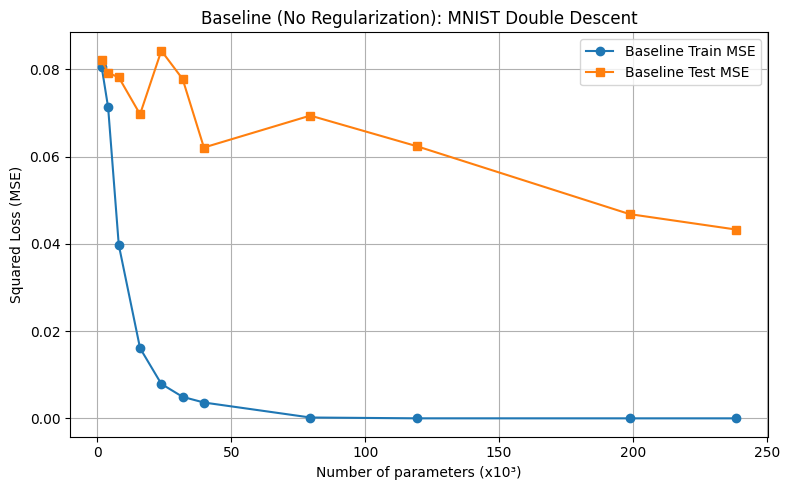

In [4]:
# Build DataLoaders (using raw ToTensor)
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

baseline_results = []
prev_model = None
prev_w = None

for w in widths:
    # If previous model exists and w ≤ interp_thresh, copy weights
    reuse = (prev_w, prev_model) if (prev_model is not None and w <= interp_thresh) else None
    net = make_model(w, reuse_from=reuse)
    prev_model, prev_w = net, w

    # SGD optimizer, no weight_decay
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.95)

    # LR scheduler only for small widths
    lr_scheduler = None
    if w <= interp_thresh:
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

    # Training loop
    for epoch in range(1, 6001):
        net.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            out = net(x)
            loss = mse(out, one_hot(y))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate on training set
        train_mse, train_err = eval_metrics(net, train_loader)
        if w <= interp_thresh:
            lr_scheduler.step()
        # Early stop if zero train error
        if train_err == 0 and w <= interp_thresh:
            print(f"(Baseline) Early stop at epoch {epoch} for width {w} (train error = 0)")
            break

    # Evaluate on test set
    test_mse, test_err = eval_metrics(net, test_loader)
    param_count = count_params(net)
    print(f"(Baseline) w={w:3d} | params={param_count:7d} | train_mse={train_mse:.4f} | test_mse={test_mse:.4f}")
    baseline_results.append((param_count / 1e3, train_mse, test_mse))

# Plot baseline curves
ks_base, trs_base, tes_base = zip(*baseline_results)
plt.figure(figsize=(8, 5))
plt.plot(ks_base, trs_base, '-o', label='Baseline Train MSE')
plt.plot(ks_base, tes_base, '-s', label='Baseline Test MSE')
plt.xlabel('Number of parameters (x10³)')
plt.ylabel('Squared Loss (MSE)')
plt.title("Baseline (No Regularization): MNIST Double Descent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5) L2 REGULARIZATION EXPERIMENT (with normalization, no dropout)

Sampled train set mean = 0.1298,  std = 0.3071
(L2) w=  2 | params=   1600 | train_mse=0.0762 | test_mse=0.0740
(L2) w=  5 | params=   3985 | train_mse=0.0579 | test_mse=0.0524
(L2) w= 10 | params=   7960 | train_mse=0.0366 | test_mse=0.0277
(L2) w= 20 | params=  15910 | train_mse=0.0356 | test_mse=0.0255
(L2) w= 30 | params=  23860 | train_mse=0.0351 | test_mse=0.0261
(L2) w= 40 | params=  31810 | train_mse=0.0357 | test_mse=0.0261
(L2) w= 50 | params=  39760 | train_mse=0.0347 | test_mse=0.0257
(L2) w=100 | params=  79510 | train_mse=0.0347 | test_mse=0.0252
(L2) w=150 | params= 119260 | train_mse=0.0337 | test_mse=0.0241
(L2) w=250 | params= 198760 | train_mse=0.0339 | test_mse=0.0246
(L2) w=300 | params= 238510 | train_mse=0.0338 | test_mse=0.0242


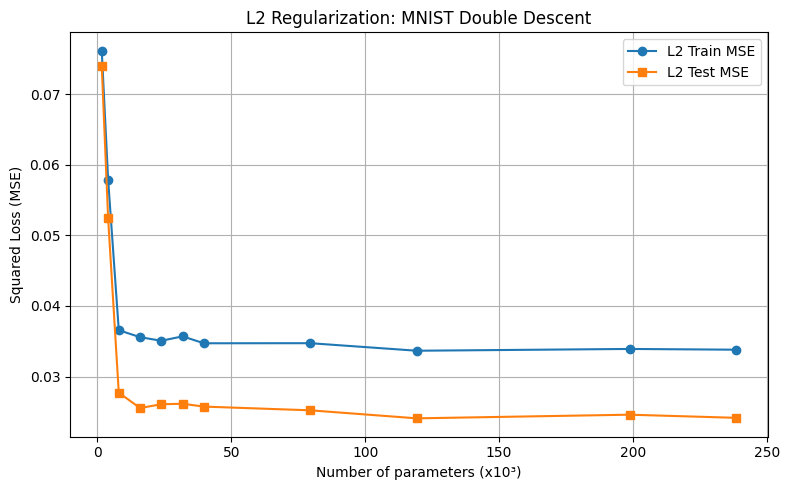

In [5]:
# 5.1) Compute mean & std over train_ds (still raw ToTensor)
loader_for_stats = DataLoader(train_ds, batch_size=128, shuffle=False)
sum_, sum2_, numel = 0.0, 0.0, 0
for x, _ in loader_for_stats:
    sum_  += x.sum()
    sum2_ += (x**2).sum()
    numel += x.numel()

mean = sum_ / numel
std = torch.sqrt(sum2_ / numel - mean**2)
print(f"Sampled train set mean = {mean.item():.4f},  std = {std.item():.4f}")

# 5.2) Swap in Normalize transform for both train and test
norm_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean.item(),), (std.item(),))
])
full_train.transform = norm_transform
test_ds.transform = norm_transform

# 5.3) Re-create train_ds so it uses normalized images
train_ds = Subset(full_train, indices)

# 5.4) Rebuild DataLoaders (now pulling normalized data)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

l2_results = []
prev_model = None
prev_w = None

for w in widths:
    reuse = (prev_w, prev_model) if (prev_model is not None and w <= interp_thresh) else None
    net = make_model(w, reuse_from=reuse)
    prev_model, prev_w = net, w

    # SGD with L2 (weight_decay=0.01)
    optimizer = optim.SGD(
        net.parameters(),
        lr=0.1,
        momentum=0.95,
        weight_decay=0.01   # ← L2 regularization
    )
    lr_scheduler = None
    if w <= interp_thresh:
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

    for epoch in range(1, 6001):
        net.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            out  = net(x)
            loss = mse(out, one_hot(y))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_mse, train_err = eval_metrics(net, train_loader)
        if w <= interp_thresh:
            lr_scheduler.step()
        if train_err == 0 and w <= interp_thresh:
            print(f"(L2) Early stop at epoch {epoch} for width {w} (train error = 0)")
            break

    test_mse, test_err = eval_metrics(net, test_loader)
    param_count = count_params(net)
    print(f"(L2) w={w:3d} | params={param_count:7d} | train_mse={train_mse:.4f} | test_mse={test_mse:.4f}")
    l2_results.append((param_count / 1e3, train_mse, test_mse))

# Plot L2 curves
ks_l2, trs_l2, tes_l2 = zip(*l2_results)
plt.figure(figsize=(8, 5))
plt.plot(ks_l2, trs_l2, '-o', label='L2 Train MSE')
plt.plot(ks_l2, tes_l2, '-s', label='L2 Test MSE')
plt.xlabel('Number of parameters (x10³)')
plt.ylabel('Squared Loss (MSE)')
plt.title("L2 Regularization: MNIST Double Descent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6) DROPOUT EXPERIMENT (no L2, with normalization)


--- Dropout p = 0.20 ---
(Dropout 0.20) w=  2 | params=   1600 | train_mse=0.0900 | test_mse=0.0900
(Dropout 0.20) w=  5 | params=   3985 | train_mse=0.0900 | test_mse=0.0900
(Dropout 0.20) w= 10 | params=   7960 | train_mse=0.0900 | test_mse=0.0901
(Dropout 0.20) w= 20 | params=  15910 | train_mse=0.0398 | test_mse=0.0597
(Dropout 0.20) w= 30 | params=  23860 | train_mse=0.0268 | test_mse=0.0621
(Dropout 0.20) w= 40 | params=  31810 | train_mse=0.0132 | test_mse=0.0537
(Dropout 0.20) w= 50 | params=  39760 | train_mse=0.0119 | test_mse=0.0496
(Dropout 0.20) w=100 | params=  79510 | train_mse=0.0075 | test_mse=0.0375
(Dropout 0.20) w=150 | params= 119260 | train_mse=0.0058 | test_mse=0.0327
(Dropout 0.20) w=250 | params= 198760 | train_mse=0.0032 | test_mse=0.0288
(Dropout 0.20) w=300 | params= 238510 | train_mse=0.0020 | test_mse=0.0274

--- Dropout p = 0.50 ---
(Dropout 0.50) w=  2 | params=   1600 | train_mse=0.0900 | test_mse=0.0900
(Dropout 0.50) w=  5 | params=   3985 | train_ms

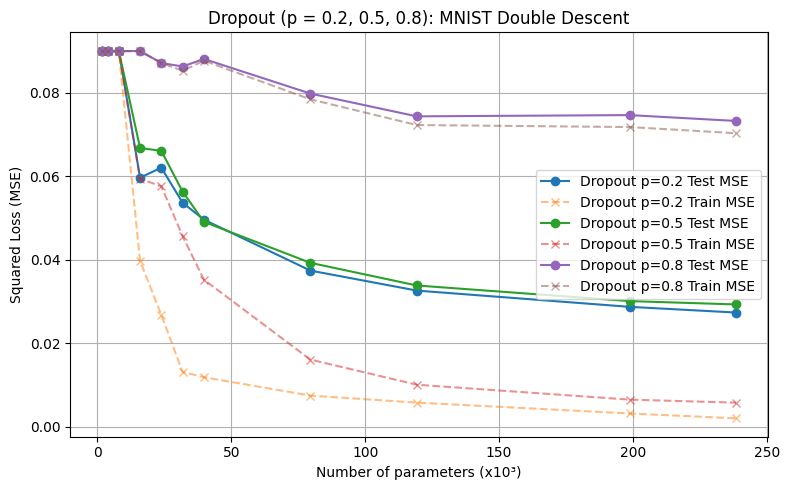

In [6]:
# Define dropout probabilities to sweep
dropout_probs = [0.2, 0.5, 0.8]

# Redefine model factory to accept dropout probability
def make_model_dropout(width, dropout_p, reuse_from=None):
    layers = [
        nn.Flatten(),
        nn.Linear(784, width),
        nn.ReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(width, 10)
    ]
    net = nn.Sequential(*layers).to(device)

    # Weight reuse logic (same as before, but second layer is index -1 instead of 3)
    if reuse_from is not None:
        prev_w, prev_net = reuse_from
        k = min(prev_w, width)
        with torch.no_grad():
            net[1].weight[:k].copy_(prev_net[1].weight[:k])
            net[1].bias[:k].copy_(prev_net[1].bias[:k])
            net[-1].weight[:, :k].copy_(prev_net[-1].weight[:, :k])
            net[-1].bias.copy_(prev_net[-1].bias)
    return net

all_results_dropout = {}

for p_drop in dropout_probs:
    print(f"\n--- Dropout p = {p_drop:.2f} ---")
    results, prev_model, prev_w = [], None, None

    for w in widths:
        reuse = (prev_w, prev_model) if (prev_model is not None and w <= interp_thresh) else None
        net = make_model_dropout(w, dropout_p=p_drop, reuse_from=reuse)
        prev_model, prev_w = net, w

        # SGD optimizer with no weight_decay
        optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.95)
        lr_scheduler = None
        if w <= interp_thresh:
            lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

        # Training loop
        for epoch in range(1, 6001):
            net.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                out = net(x)
                loss = mse(out, one_hot(y))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if w <= interp_thresh:
                lr_scheduler.step()

            # Check for zero training error to early stop
            train_mse, train_err = eval_metrics(net, train_loader)
            if train_err == 0 and w <= interp_thresh:
                print(f"(Dropout {p_drop:.2f}) Early stop at epoch {epoch} for width {w}")
                break

        test_mse, test_err = eval_metrics(net, test_loader)
        param_count = count_params(net)
        print(f"(Dropout {p_drop:.2f}) w={w:3d} | params={param_count:7d} | train_mse={train_mse:.4f} | test_mse={test_mse:.4f}")
        results.append((param_count / 1e3, train_mse, test_mse))

    all_results_dropout[p_drop] = results

# Plot dropout curves (only Test MSE, plus dashed Train MSE)
plt.figure(figsize=(8, 5))
for p_drop, curves in all_results_dropout.items():
    ks_d, trs_d, tes_d = zip(*curves)
    plt.plot(ks_d, tes_d, marker='o', label=f"Dropout p={p_drop} Test MSE")
    plt.plot(ks_d, trs_d, marker='x', linestyle='--', alpha=0.5, label=f"Dropout p={p_drop} Train MSE")

plt.xlabel('Number of parameters (x10³)')
plt.ylabel('Squared Loss (MSE)')
plt.title("Dropout (p = 0.2, 0.5, 0.8): MNIST Double Descent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()